# Initializing config, dataset and the oracle

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dataset import Config, Dataset
from oracle import Oracle
from active_learning import Learner

config = Config(70, 10)
data = Dataset(config)
orac_lc = Oracle(data, config)
orac_ms = Oracle(data, config)
orac_h = Oracle(data, config)
orac_rand = Oracle(data, config)

# Visualizing the digit dataset after PCA

In [3]:
from sklearn.decomposition import PCA

# Define our PCA transformer and fit it onto our raw dataset.
pca = PCA(n_components=2, random_state=2)
decomposed_digit = pca.fit_transform(X = data.x_raw)

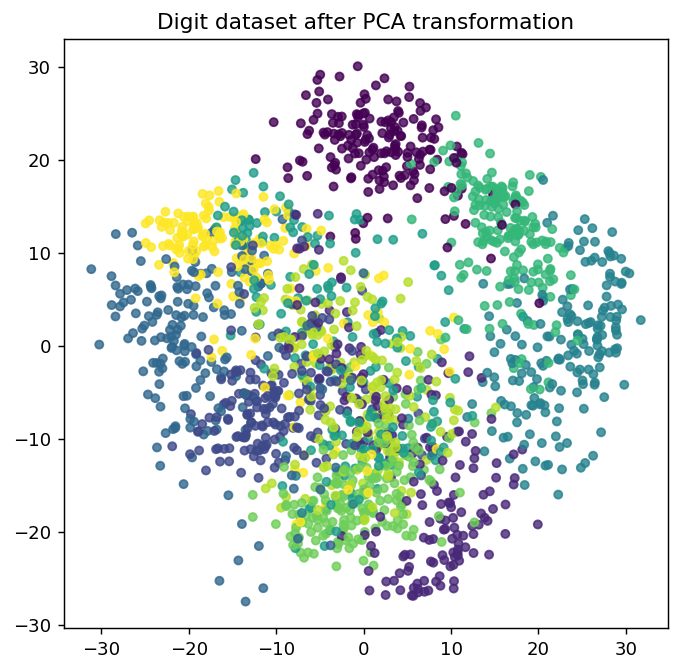

In [4]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Isolate the data we'll need for plotting.
x_component, y_component = decomposed_digit[:, 0], decomposed_digit[:, 1]

test_c1, test_c2 = [], []
for i in range(len(data.test_indices)):
    test_c1.append(x_component[data.test_indices[i]])
    test_c2.append(y_component[data.test_indices[i]])

# Plot our dimensionality-reduced (via PCA) dataset.
plt.figure(figsize=(6, 6), dpi=130)
plt.scatter(x = x_component, y = y_component, c = data.y_raw, cmap = 'viridis', s = 20, alpha = 8/10)
plt.title('Digit dataset after PCA transformation')
plt.show()

# Instantiating a Learner instance

In [5]:
from sklearn import svm

clf = svm.SVC(gamma=0.001, probability=True)

least_count_learner = Learner([clf], "uncertainty", uncertainty = "lc")
margin_sampling_learner = Learner([clf], "uncertainty", uncertainty = "ms")
entropy_learner = Learner([clf], "uncertainty", uncertainty = "entropy")
random_learner = Learner([clf], "uncertainty", uncertainty = "random")

# Initial training for the active learners

In [6]:
least_count_learner.train(orac_lc)
margin_sampling_learner.train(orac_ms)
entropy_learner.train(orac_h)
random_learner.train(orac_rand)

In [7]:
initial_pred_lc = least_count_learner.predict(data.test_X)
initial_pred_ms = margin_sampling_learner.predict(data.test_X)
initial_pred_h = entropy_learner.predict(data.test_X)
initial_pred_rand = random_learner.predict(data.test_X)

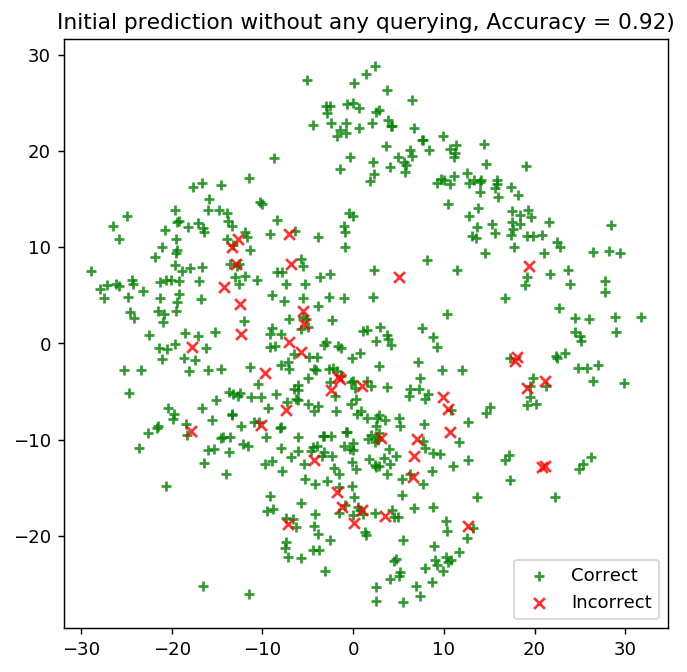

In [8]:
import numpy as np

is_correct = (initial_pred_lc == np.array(data.test_Y))

fig, ax1 = plt.subplots(figsize=(6, 6), dpi=130)
fig.suptitle = "Initial prediction without any querying"

ax1.scatter(x=np.array(test_c1)[is_correct],  y=np.array(test_c2)[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax1.scatter(x=np.array(test_c1)[~is_correct], y=np.array(test_c2)[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
ax1.legend(loc='lower right')
ax1.set_title("Initial prediction without any querying, Accuracy = {score:.2f})".format(score=least_count_learner.test_score(data)))

plt.show()

# Querying

In [9]:
''' 4 consecutive queries for labelling 10% data in each iteration and evaluating the test performance for 
all the possible informativeness metrics
'''
unqueried_score = least_count_learner.test_score(data)
performance_lc = [unqueried_score]
performance_ms = [unqueried_score]
performance_h = [unqueried_score]
performance_rand = [unqueried_score]

query_count = 0
while(performance_lc[-1] < 0.97):
    # streaming over the least confidence pool of unlabeled data
    for i in range(len(orac_lc.pool_X)):
        ch = least_count_learner.query(data, orac_lc, stream = i, config = config)
        if(ch == 1):
            query_count = query_count + 1
            least_count_learner.train(orac_lc)
            accuracy = least_count_learner.test_score(data)
            performance_lc.append(accuracy)
            print('Accuracy of least confidence after query {n}: {acc:0.4f}'.format(n=query_count, acc=accuracy))
            if(accuracy >= 0.97):
                break

query_count = 0
while(performance_ms[-1] < 0.97):
    # streaming over the least confidence pool of unlabeled data
    for i in range(len(orac_ms.pool_X)):
        ch = margin_sampling_learner.query(data, orac_ms, stream = i, config = config)
        if(ch == 1):
            query_count = query_count + 1
            margin_sampling_learner.train(orac_ms)
            accuracy = margin_sampling_learner.test_score(data)
            performance_ms.append(accuracy)
            print('Accuracy of margin sample after query {n}: {acc:0.4f}'.format(n=query_count, acc=accuracy))
            if(accuracy >= 0.97):
                break

query_count = 0
while(performance_h[-1] < 0.97):
    # streaming over the least confidence pool of unlabeled data
    for i in range(len(orac_h.pool_X)):
        ch = entropy_learner.query(data, orac_h, stream = i, config = config)
        if(ch == 1):
            query_count = query_count + 1
            entropy_learner.train(orac_h)
            accuracy = entropy_learner.test_score(data)
            performance_h.append(accuracy)
            print('Accuracy of margin sample after query {n}: {acc:0.4f}'.format(n=query_count, acc=accuracy))
            if(accuracy >= 0.97):
                break
                
query_count = 0
while(performance_rand[-1] < 0.97):
    # streaming over the least confidence pool of unlabeled data
    for i in range(len(orac_rand.pool_X)):
        ch = random_learner.query(data, orac_rand, stream = -2, config = config)
        if(ch == 1):
            query_count = query_count + 1
            random_learner.train(orac_rand)
            accuracy = random_learner.test_score(data)
            performance_rand.append(accuracy)
            print('Accuracy of random sample after query {n}: {acc:0.4f}'.format(n=query_count, acc=accuracy))
            if(accuracy >= 0.97):
                break

Accuracy of least confidence after query 1: 0.9333
Accuracy of least confidence after query 2: 0.9333
Accuracy of least confidence after query 3: 0.9352
Accuracy of least confidence after query 4: 0.9333
Accuracy of least confidence after query 5: 0.9333
Accuracy of least confidence after query 6: 0.9389
Accuracy of least confidence after query 7: 0.9389
Accuracy of least confidence after query 8: 0.9407
Accuracy of least confidence after query 9: 0.9407
Accuracy of least confidence after query 10: 0.9407
Accuracy of least confidence after query 11: 0.9370
Accuracy of least confidence after query 12: 0.9333
Accuracy of least confidence after query 13: 0.9315
Accuracy of least confidence after query 14: 0.9333
Accuracy of least confidence after query 15: 0.9389
Accuracy of least confidence after query 16: 0.9352
Accuracy of least confidence after query 17: 0.9333
Accuracy of least confidence after query 18: 0.9407
Accuracy of least confidence after query 19: 0.9463
Accuracy of least con

Accuracy of margin sample after query 85: 0.9537
Accuracy of margin sample after query 86: 0.9537
Accuracy of margin sample after query 87: 0.9537
Accuracy of margin sample after query 88: 0.9519
Accuracy of margin sample after query 89: 0.9537
Accuracy of margin sample after query 90: 0.9519
Accuracy of margin sample after query 91: 0.9519
Accuracy of margin sample after query 92: 0.9500
Accuracy of margin sample after query 93: 0.9519
Accuracy of margin sample after query 94: 0.9593
Accuracy of margin sample after query 95: 0.9593
Accuracy of margin sample after query 96: 0.9593
Accuracy of margin sample after query 97: 0.9593
Accuracy of margin sample after query 98: 0.9593
Accuracy of margin sample after query 99: 0.9593
Accuracy of margin sample after query 100: 0.9593
Accuracy of margin sample after query 101: 0.9611
Accuracy of margin sample after query 102: 0.9611
Accuracy of margin sample after query 103: 0.9611
Accuracy of margin sample after query 104: 0.9611
Accuracy of mar

Accuracy of random sample after query 136: 0.9481
Accuracy of random sample after query 137: 0.9481
Accuracy of random sample after query 138: 0.9481
Accuracy of random sample after query 139: 0.9481
Accuracy of random sample after query 140: 0.9481
Accuracy of random sample after query 141: 0.9481
Accuracy of random sample after query 142: 0.9519
Accuracy of random sample after query 143: 0.9500
Accuracy of random sample after query 144: 0.9500
Accuracy of random sample after query 145: 0.9500
Accuracy of random sample after query 146: 0.9500
Accuracy of random sample after query 147: 0.9519
Accuracy of random sample after query 148: 0.9519
Accuracy of random sample after query 149: 0.9556
Accuracy of random sample after query 150: 0.9556
Accuracy of random sample after query 151: 0.9556
Accuracy of random sample after query 152: 0.9556
Accuracy of random sample after query 153: 0.9556
Accuracy of random sample after query 154: 0.9556
Accuracy of random sample after query 155: 0.9574


Accuracy of random sample after query 301: 0.9648
Accuracy of random sample after query 302: 0.9648
Accuracy of random sample after query 303: 0.9648
Accuracy of random sample after query 304: 0.9648
Accuracy of random sample after query 305: 0.9648
Accuracy of random sample after query 306: 0.9648
Accuracy of random sample after query 307: 0.9648
Accuracy of random sample after query 308: 0.9648
Accuracy of random sample after query 309: 0.9741


# Plotting Improvements with successive querying

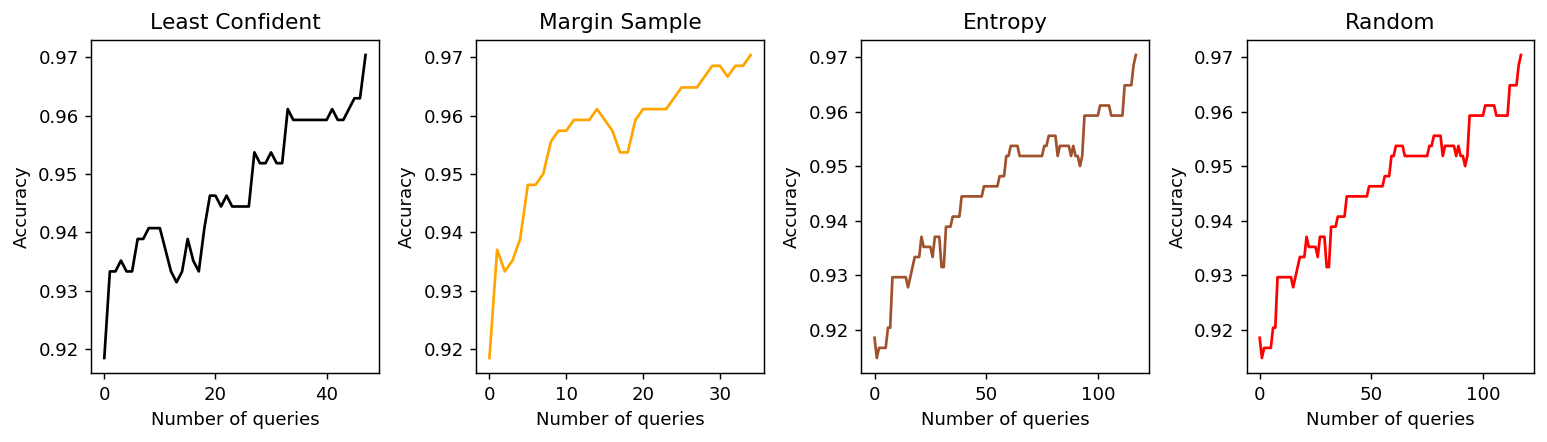

In [10]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3.5), dpi = 130)

cols = ['Least Count', 'Marginal Sampling', 'Entropy']

label_proportion1 = list(range(len(performance_lc)))
label_proportion2 = list(range(len(performance_ms)))
label_proportion3 = list(range(len(performance_h)))
label_production4 = list(range(len(performance_rand)))

axs[0].plot(label_proportion1, performance_lc, label = "Least Count", color='black')
axs[1].plot(label_proportion2, performance_ms, label = "Margin Sample", color='orange')
axs[2].plot(label_proportion3, performance_h, label = "Entropy", color='sienna')
axs[3].plot(label_proportion3, performance_h, label = "Random", color='red')

axs[0].set_title('Least Confident')
axs[1].set_title('Margin Sample')
axs[2].set_title('Entropy')
axs[3].set_title('Random')

axs[0].set_xlabel('Number of queries')
axs[1].set_xlabel('Number of queries')
axs[2].set_xlabel('Number of queries')
axs[3].set_xlabel('Number of queries')


axs[0].set_ylabel('Accuracy')
axs[1].set_ylabel('Accuracy')
axs[2].set_ylabel('Accuracy')
axs[3].set_ylabel('Accuracy')

fig.tight_layout()
plt.show()

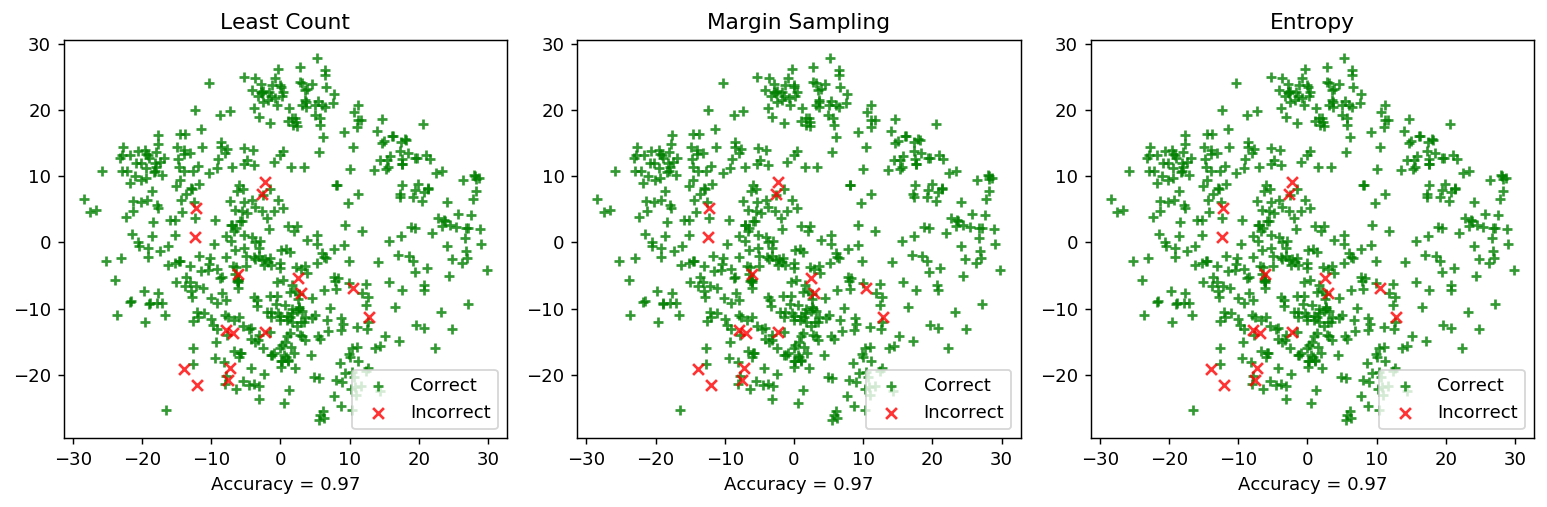

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), dpi = 130)

pred_lc = least_count_learner.predict(data.test_X)
pred_ms = margin_sampling_learner.predict(data.test_X)    
pred_h = entropy_learner.predict(data.test_X)

is_correct = (pred_lc == np.array(data.test_Y))

axs[0].set_title("Least Count")
axs[1].set_title("Margin Sampling")
axs[2].set_title("Entropy")

axs[0].scatter(x=np.array(test_c1)[is_correct],  y=np.array(test_c2)[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
axs[0].scatter(x=np.array(test_c1)[~is_correct], y=np.array(test_c2)[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
axs[0].legend(loc='lower right')
axs[0].set_xlabel("Accuracy = {score:.2f}".format(nq = i-1, score=least_count_learner.test_score(data)))

is_correct = (pred_ms == np.array(data.test_Y))

axs[1].scatter(x=np.array(test_c1)[is_correct],  y=np.array(test_c2)[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
axs[1].scatter(x=np.array(test_c1)[~is_correct], y=np.array(test_c2)[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
axs[1].legend(loc='lower right')
axs[1].set_xlabel("Accuracy = {score:.2f}".format(nq = i-1, score=margin_sampling_learner.test_score(data)))

is_correct = (pred_h == np.array(data.test_Y))

axs[2].scatter(x=np.array(test_c1)[is_correct],  y=np.array(test_c2)[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
axs[2].scatter(x=np.array(test_c1)[~is_correct], y=np.array(test_c2)[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
axs[2].legend(loc='lower right')
axs[2].set_xlabel("Accuracy = {score:.2f}".format(nq = i-1, score=entropy_learner.test_score(data)))


fig.tight_layout()
plt.show()